# Using RNNs/Lstms to predict MRL for a given 5' UTR

In this notebook, we will implement an RNN model on the data, evaluate and analyze the output. 

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import  Dense, Embedding, LSTM, Bidirectional
from keras.layers import Dropout
from keras.layers.core import Dense
import seaborn as sns
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
import scipy.stats as stats

from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['agg.path.chunksize'] = 0
mpl.rcParams.update( mpl.rc_params() )
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': 'bold'})
plt.rc('font', family='serif')

## 1. We read the preprocessed data. 

In [18]:
#We load the data
data_path = "Data/GSM3130435_egfp_unmod_1_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')

## 2. We split the data in training, validation and testing set.

In [21]:
#We divide the test set between training (90%) and testing set (10%)
df = df.sample(frac = 1)
df_test = df.iloc[:28000]
df_train = df.iloc[28000:]

In [22]:
#All one hot encodings are saved as strings of lists, so we convert them to np.array
X_train = df_train["one-hot encoding"].apply(ast.literal_eval)
y_train = df_train["rl"]

In [23]:
X_train = [np.array(x) for x in X_train]

In [24]:
X_train = np.array(X_train)
X_train.shape

(252000, 50, 4)

In [25]:
#Sanity check 
print("X_train shape: {}".format(X_train.shape))

X_train shape: (252000, 50, 4)


## 3. We build our model and train it using our datasets.

In [12]:
batch_size = 128
input_dim = 50
input_dim2 = 4
units = 75

def train_lstm_model(x, y, border_mode='same', inp_len=50, nodes=40,
                dropout1=0.2, dropout2=0.2, dropout3=0.2, nb_epoch=3):
    """This function build our model and fits it."""
    model = Sequential()
    model.add(LSTM(units=75, input_shape=(50, 4), return_sequences=True))
    model.add(LSTM(units=75, input_shape=(50, 4), return_sequences=True))
    model.add(Dropout(dropout2))
    model.add(LSTM(units=75, input_shape=(50, 4), return_sequences=True))

    model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)
    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [26]:
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [60]:
model = train_lstm_model(X_train, y_train, nb_epoch=10)

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
1969/1969 [==============================] - 305s 152ms/step - loss: 2.7177
Epoch 2/10
1969/1969 [==============================] - 289s 147ms/step - loss: 1.3560
Epoch 3/10
1969/1969 [==============================] - 271s 138ms/step - loss: 1.0382
Epoch 4/10
1969/1969 [==============================] - 6231s 3s/step - loss: 0.8435
Epoch 5/10
1969/1969 [==============================] - 259s 131ms/step - loss: 0.6016
Epoch 6/10
1969/1969 [==============================] - 267s 136ms/step - loss: 0.4693
Epoch 7/10
1969/1969 [==============================] - 259s 132ms/step - loss: 0.4097
Epoch 8/10
1969/1969 [==============================] - 268s 136ms/step - loss: 0.3720
Epoch 9/10
1969/1969 [==============================] - 266s 135ms/step - loss: 0.3444
Epoch 10/10
1969/1969 [==============================] - 436s 221ms/step - loss: 0.3285


In [27]:
#All one hot encodings are saved as strings of lists, so we convert them to np.array for the testing set
X_test = df_test["one-hot encoding"].apply(ast.literal_eval)
X_test = np.array([np.array(x) for x in X_test])

In [28]:
preds = model.predict(X_test).reshape(-1)
preds

array([3.3912015, 4.0530114, 3.890226 , ..., 5.383596 , 7.7687035,
       7.825171 ], dtype=float32)

In [29]:
df_test["pred rl"] = preds.tolist()
df_test["pred rl"]

<ipython-input-29-42c4b484d1b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred rl"] = preds.tolist()


0        3.391201
1        4.053011
2        3.890226
3        4.069327
4        4.746781
           ...   
27995    6.986712
27996    8.011992
27997    5.383596
27998    7.768703
27999    7.825171
Name: pred rl, Length: 28000, dtype: float64

In [30]:
r = r2(df_test["rl"], df_test["pred rl"])
print('r-squared = ', r)

r-squared =  0.9410943700395088


In [31]:
from sklearn.metrics import r2_score
r2_score(df_test["rl"], df_test["pred rl"])

0.9336943856336166

In [24]:
model.save('./saved_models/3_lstms.hdf5')

## 4. We analyze the output

In [9]:
model = keras.models.load_model('./saved_models/3_lstms.hdf5')

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


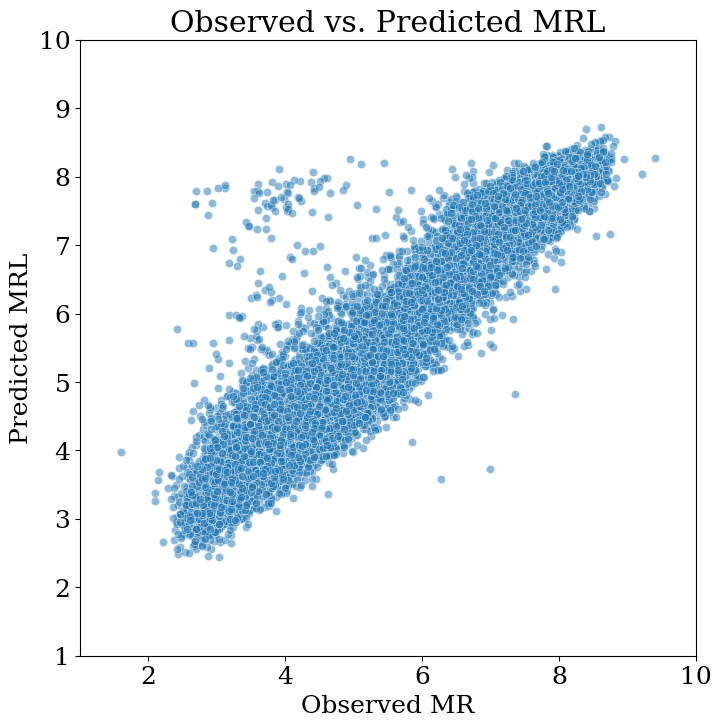

In [32]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(df_test['rl'], df_test["pred rl"],linewidth = 0.5, alpha=0.5)
plt.xlabel('Observed MR')
plt.ylabel('Predicted MRL') 
plt.xlim(1, 10)
plt.ylim(1, 10)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('Observed vs. Predicted MRL')
#plt.savefig("CNN1.pdf", bbox_inches = "tight")
plt.show()

In [33]:
df_test_atg = df_test[df_test['utr'].apply(lambda x: 'ATG' in x)]
df_test_no_atg = df_test[df_test['utr'].apply(lambda x: 'ATG' not in x)]

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


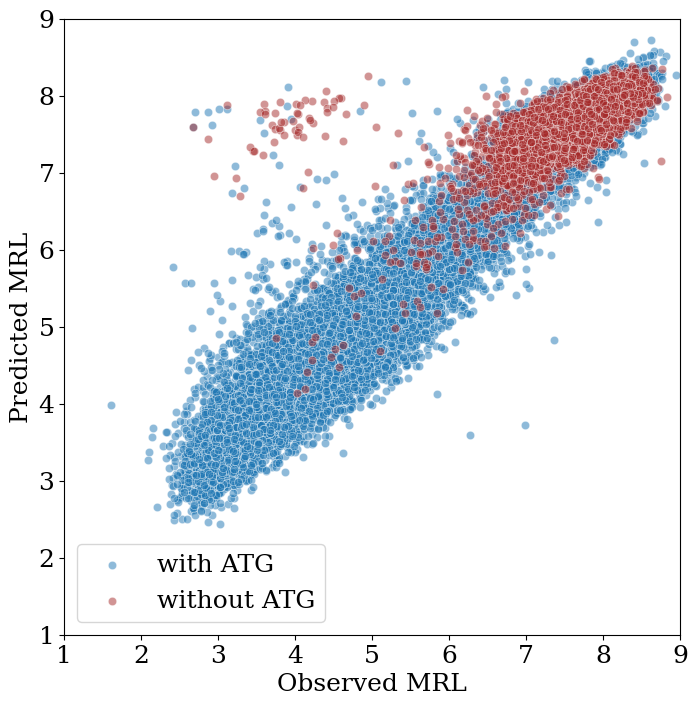

In [36]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(df_test_atg["rl"], df_test_atg["pred rl"],linewidth = 0.5, alpha=0.5, label = 'with ATG')
ax = sns.scatterplot(df_test_no_atg["rl"], df_test_no_atg["pred rl"],
                 linewidth = 0.5, alpha=0.5, label = 'without ATG', color = 'brown', legend = 'auto')
plt.xlim(1, 9)
plt.ylim(1, 9)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set(xlabel = 'Observed MRL', ylabel = 'Predicted MRL')
plt.savefig("LSTMs_fixed_length.pdf", bbox_inches = "tight")
plt.show()

## Analysis of the output

In [38]:
df_test["rl class"] = df_test["rl"].apply(round)
df_test["pred rl class"] = df_test["pred rl"].apply(round)
df_test["pred rl class"]
df_test["rl class"]

<ipython-input-38-ce0e2bb61bb8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["rl class"] = df_test["rl"].apply(round)
<ipython-input-38-ce0e2bb61bb8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred rl class"] = df_test["pred rl"].apply(round)


0        3
1        4
2        3
3        4
4        5
        ..
27995    8
27996    8
27997    7
27998    8
27999    8
Name: rl class, Length: 28000, dtype: int64

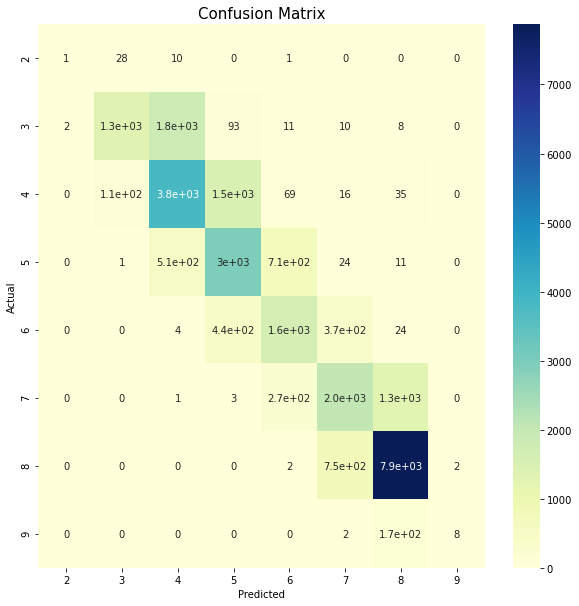

In [49]:
#Confusion matrix of predictions
confusion_matrix = pd.crosstab(df_test["rl class"], df_test["pred rl class"], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

In [43]:
mispredictions_df = df_test[df_test["rl class"] != df_test["pred rl class"]]
mispredictions_df.head()

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r12,r13,rl,Selection,one-hot encoding,Length,scaled_rl,pred rl,rl class,pred rl class
2,128224,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,0.000088,0.000081,0.000059,0.000035,0.000017,0.000016,0.000009,0.000009,...,0.028963,0.041985,3.334524,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.948147,3.890226,3,4
8,112852,GATACGCATAAACGTTCCATGCTATGGTATGGCCCCTCAAGGCGCT...,0.000046,0.000050,0.000055,0.000048,0.000024,0.000021,0.000011,0.000011,...,0.038794,0.043036,4.224131,Selected Data,"[[0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [1,...",50,-1.396191,6.074993,4,6
12,45389,GTGATCAGCTCCTGATCCACGCGTTTAAGCAAAGTAGGTGAAGCTC...,0.000014,0.000011,0.000015,0.000023,0.000026,0.000040,0.000044,0.000034,...,0.048551,0.052085,6.476640,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1,...",50,0.001378,7.991141,6,8
15,152794,GTAATCGTAGAAATGGTTCAGAATGTGGAAGAGGATCATGTAGGCA...,0.000064,0.000070,0.000053,0.000029,0.000018,0.000014,0.000008,0.000008,...,0.029869,0.034522,3.479787,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1,...",50,-1.858019,3.763340,3,4
20,102473,CATGGCGAAGCCCTTCCAATGGGAGCTCGCTAAGCGAGCGCGTGCT...,0.000103,0.000076,0.000033,0.000016,0.000009,0.000010,0.000005,0.000006,...,0.023901,0.032309,2.689169,Selected Data,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,...",50,-2.348558,4.195653,3,4


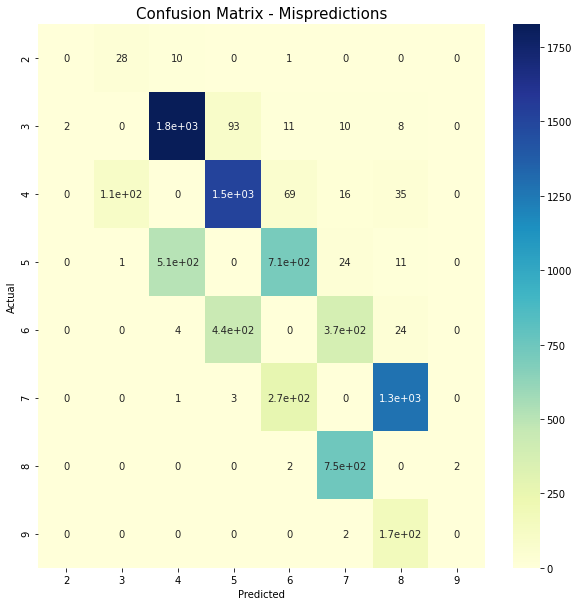

In [48]:
#Confusion matrix of predictions
confusion_matrix = pd.crosstab(mispredictions_df["rl class"], mispredictions_df["pred rl class"], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix - Mispredictions", fontsize = 15)
plt.show()

In [57]:
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
print("Precision = ", np.mean(precision))
precision

Precision =  0.6663806513515238


Predicted
2    0.333333
3    0.906142
4    0.619825
5    0.592725
6    0.605253
7    0.635856
8    0.837910
9    0.800000
dtype: float64

In [58]:
print("Precision = ", np.mean(recall))
recall

Precision =  0.5007764961998424


Actual
2    0.025000
3    0.402267
4    0.687287
5    0.703302
6    0.661277
7    0.568812
8    0.912812
9    0.045455
dtype: float64

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_test = df_test["rl class"]
y_pred = df_test["pred rl class"]

print("Precision Score : ",precision_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.7034285714285714
Recall Score :  0.7034285714285714
